# Loading tracks predicted by FairMOT 

In [1]:
# # Developer

# %cd /kaggle
# from IPython.display import clear_output
# pat = input('GitHub Personal Access Token:')
# clear_output()
# ! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

# # %cd /kaggle/nfl_helmet_assignment_kaggle/
# # ! git pull

In [2]:
# User

! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [3]:
import os, sys
from tqdm.auto import tqdm
import multiprocessing
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Video, display

sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')

from helmet_tracker.utils.score import check_submission, NFLAssignmentScorer
from helmet_tracker.utils.features import add_track_features
from helmet_tracker.utils.video import video_with_predictions

In [4]:
BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')

In [5]:
# FairMOT inference results

# debug-train videos
video_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/train'
dir_demo = '/kaggle/input/nfldata05-fairmot-demo-trainsample/demo_debug'

# # test videos
# video_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/test'
# dir_demo = '/kaggle/input/nfl05-fairmot-demo/demos'

In [6]:
# Available videos
! ls {dir_demo}

57700_001264_Endzone   57783_003374_Endzone   57997_003691_Endzone
57700_001264_Sideline  57783_003374_Sideline  57997_003691_Sideline


In [7]:
# FairMOT outputs the following for a video
! ls {dir_demo}/57783_003374_Sideline/

frame  results.mp4  results.txt


In [8]:
video = '57997_003691_Endzone'

In [9]:
%%time

# Load FairMOT inference output txt
pth_tracks = os.path.join(dir_demo, video, 'results.txt')
columns = ['frame', 'id', 'x1', 'y1', 'w', 'h']
df_tracks = pd.read_csv(pth_tracks, header=None, usecols=range(len(columns)), 
                        names=columns)

# Find height and width of video
pth_video = os.path.join(video_dir, f'{video}.mp4')
cap = cv2.VideoCapture(pth_video)
fps    = cap.get(cv2.CAP_PROP_FPS)
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

# Rescale output bboxes to match video's dimensions
fairmot_video_width = 1920
fairmot_video_height = 1080
x_scale = width / fairmot_video_width
y_scale = height / fairmot_video_height
df_tracks[['x1', 'w']] = x_scale * df_tracks[['x1', 'w']]
df_tracks[['y1', 'h']] = y_scale * df_tracks[['y1', 'h']]

# Rename columns to be like for DeepSORT
df_tracks.rename(columns={'id': 'fairmot_cluster', 
                          'x1': 'left', 
                          'y1': 'top', 
                          'w': 'width', 
                          'h': 'height'}, 
                inplace=True)

for c in ['left', 'top', 'width', 'height']:
    df_tracks[c] = df_tracks[c].astype(int)

CPU times: user 47.2 ms, sys: 9.64 ms, total: 56.8 ms
Wall time: 154 ms


# Check boxes locations and dimensions

In [10]:
frame = 297

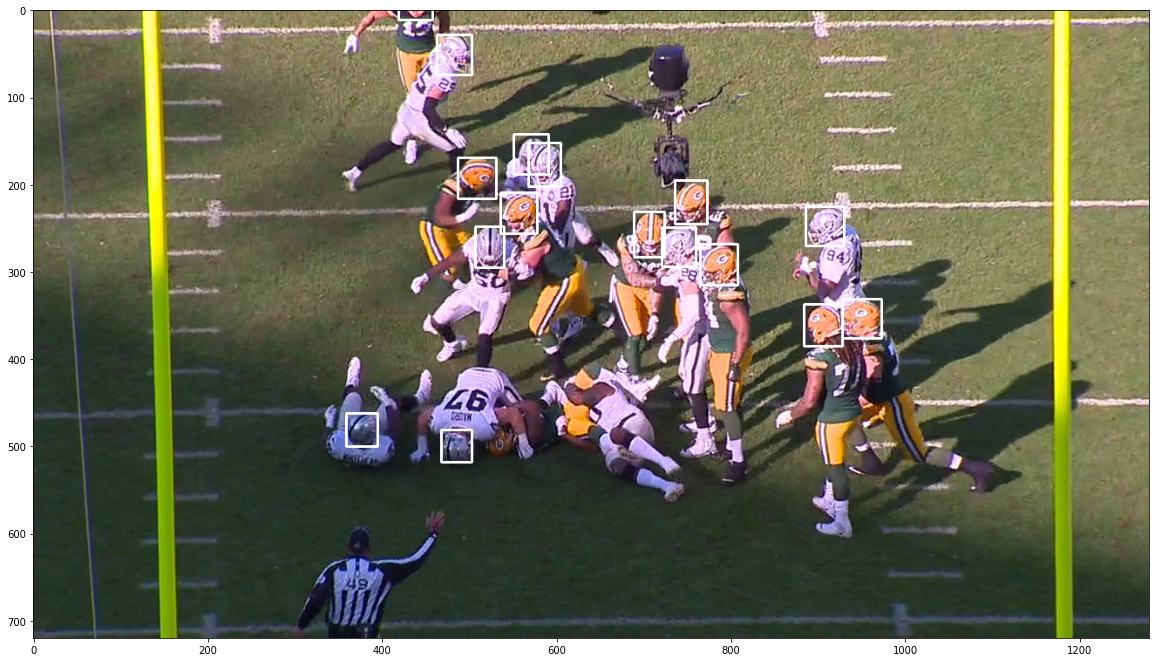

In [11]:
pth_video = os.path.join(video_dir, f'{video}.mp4')
cap = cv2.VideoCapture(pth_video)
for _ in range(frame):
    read_ok, img = cap.read()
    assert read_ok
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in df_tracks.query("frame==@frame").itertuples():
    x1 = box.left
    y1 = box.top
    x2 = x1 + box.width
    y2 = y1 + box.height
    img = cv2.rectangle(img, 
                        pt1=(x1, y1), pt2=(x2, y2), 
                        color=(255, 255, 255), thickness=2)
    
_, ax = plt.subplots(figsize=(20, 15))
ax.imshow(img);